# **SOPORTE: Proceso esquematizado para la realización del reto (Objetivo_1)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U pymgrid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.0 MB/s eta 0:00:00
  Created wheel for pymgrid: filename=pymgrid-1.2.2-py3-none-any.whl size=3492849 sha256=c617d479bb865ed9689d9968abfc5ff0b5553baddb990cc5b11ddd946c6d55e0
  Stored in directory: /root/.cache/pip/wheels/aa/9c/34/d880763dcc693c67448303756a6e1adb899bdc0d5080643030
Successfully built pymgrid


In [3]:
!pip install git+https://github.com/Wenuka/pymgrid/


  Cloning https://github.com/Wenuka/pymgrid/ to /tmp/pip-req-build-2jisa7wh
  Running command git clone --filter=blob:none --quiet https://github.com/Wenuka/pymgrid/ /tmp/pip-req-build-2jisa7wh
  Resolved https://github.com/Wenuka/pymgrid/ to commit 6a8091e1ee554c65bdb4bb229570aa94a3bf4a03
  Preparing metadata (setup.py) ... done
  Created wheel for pymgrid: filename=pymgrid-0.1.0-py3-none-any.whl size=3424052 sha256=7f63873fc867b0313668ec73a498f1c6c13b371c23439d8d5ae70b8b362225e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-6qi8vm0h/wheels/cd/b4/15/71aa9cbda578c3c22dfcbc0fb165c27772f2099892ca060bd1
Successfully built pymgrid
  Attempting uninstall: pymgrid
    Found existing installation: pymgrid 1.2.2
    Uninstalling pymgrid-1.2.2:
      Successfully uninstalled pymgrid-1.2.2


In [4]:
import gymnasium as gym

In [5]:
import sys
from pymgrid import MicrogridGenerator as mg
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import matplotlib.pyplot as plt

!python --version

Python 3.11.11


Nota: Proceso para importar carpeta "data2" en colab

In [6]:
# Selección de archivo (.zip) en Colab a partir de un cuadro de dialogo
from google.colab import files

archivo_subido = files.upload()


Saving data.zip to data.zip


In [7]:
# Unzip del fichero seleccionado
import zipfile

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [8]:
env = mg.MicrogridGenerator(nb_microgrid=5, path="./data/pymgrid_data")  # we use a custom file to simulate the load and the PV
env.generate_microgrid(verbose=False)
mg0 = env.microgrids[0]
mg0.architecture

{'PV': 1, 'battery': 1, 'genset': 0, 'grid': 1}

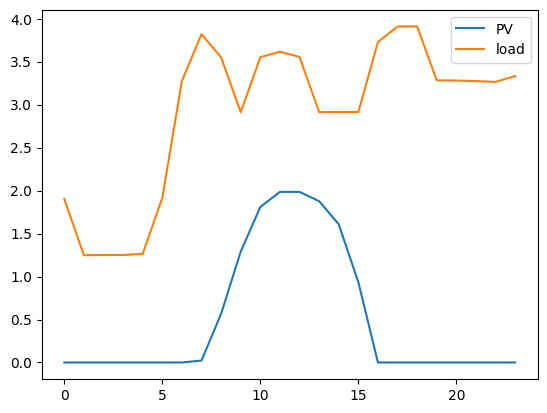

In [9]:
plt.plot(mg0.forecast_pv(), label="PV")
plt.plot(mg0.forecast_load(), label="load")
plt.legend()

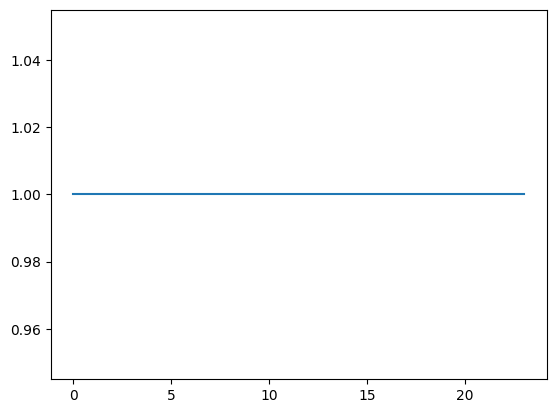

In [10]:
plt.plot(mg0.forecast_grid_status())

**Lo estados podrían ser:**
- Carga (kW)
- FV (kW)
- Bateria (% carga)
- Conexión a red (constante siempre a 1)

Finalmente, podemos definir la carga de red como: carga - FV, así que realmente tenemos **"dos estados"**:

**(Net_load, battery %)**

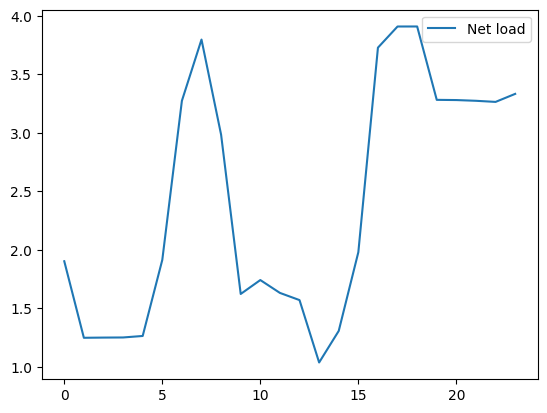

In [11]:
plt.plot(mg0.forecast_load()-mg0.forecast_pv(), label="Net load")
plt.legend()

Discretizamos el environment

Current load: 1.9025237435023625
Current PV: 0.0
Battery capacity: 16
Battery state of charge: 0.2


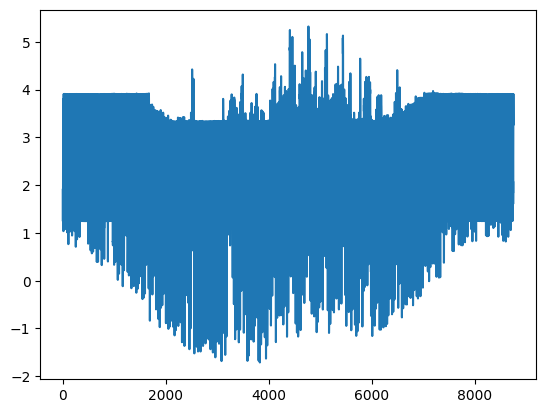

In [12]:
mg0.set_horizon(24*365) # Intervalo de tiempo sobre el cual extraer datos
overall_net_load = mg0.forecast_load()-mg0.forecast_pv()
overal_min = min(overall_net_load)
overal_max = max(overall_net_load)
discretize_interval = 1
net_load_params = (overal_min, overal_max, discretize_interval) # Variable para llamar a función
plt.plot(mg0.forecast_load()-mg0.forecast_pv(), label="Net load")

current_load = mg0.load
current_pv = mg0.pv
battery_capacity = mg0.battery.capacity
battery_state_of_charge = mg0.battery.soc

print(f"Current load: {current_load}")
print(f"Current PV: {current_pv}")
print(f"Battery capacity: {battery_capacity}")
print(f"Battery state of charge: {battery_state_of_charge}")

**Discretizar:** Para aplicarQ-learning definimos estados discretos

**Acciones:**
- Action 0: cargar batería
- Action 1: descargar batería
- Action 2: comprar de la red
- Action 3: vender a la red

**Definimos las acciones, de acuerdo a lo indicado:**

Nota: "La manera o forma de aplicar estas acciones, será explicada en el reto para que no les de a duda de como calcular cada una de ellas.

In [13]:
def actions_agent(mg0, action):
    pv = mg0.pv
    load = mg0.load
    net_load = load - pv

    # Calculamos parámetros de la bateria ###
    # Parámetros para la carga:
    capa_to_charge = mg0.battery.capa_to_charge  # remaining capacity to charge of the battery
    p_charge_max = mg0.battery.p_charge_max  # charge speed of the battery
    p_charge = max(0,min(-net_load, capa_to_charge, p_charge_max))  # Valor de carga para el periodo de tiempo definido (time stamp) charge value for the time
    # Parámetros para la descarga
    capa_to_discharge = mg0.battery.capa_to_discharge  # capacity of discharge
    p_discharge_max = mg0.battery.p_discharge_max  # per hour discharge rate
    p_discharge = max(0,min(net_load, capa_to_discharge, p_discharge_max))  # discharge value for the time

    if action == 0:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': p_charge,
                        'battery_discharge': 0,
                        'grid_import': 0,
                        'grid_export':max(0,pv - min(pv,load) - p_charge)
                       }
    elif action ==1:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': p_discharge,
                        'grid_import': max(0,load - min(pv,load) - p_discharge),
                        'grid_export':0
                       }
    elif action ==2:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': abs(net_load),
                        'grid_export':0
                       }
    elif action == 3:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': 0,
                        'grid_export':abs(net_load)
                       }

    return control_dict

**Inicializamos la Q-table:**

In [14]:
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [15]:
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym
from gymnasium import spaces
import numpy as np
class MicrogridEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, microgrid, horizon=24*7):
        super().__init__()
        self.microgrid = microgrid
        self.horizon = horizon
        self.current_step = 0

        forecast_load = self.microgrid.forecast_load()
        forecast_pv = self.microgrid.forecast_pv()
        net_load = forecast_load - forecast_pv

        self.observation_space = spaces.Box(
            low=np.array([net_load.min(), 0.0], dtype=np.float32),
            high=np.array([net_load.max(), 1.0], dtype=np.float32),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(4)

    def reset(self, seed=None, options=None):
        self.microgrid.reset()
        self.current_step = 0
        net_load = self.microgrid.load - self.microgrid.pv
        soc = self.microgrid.battery.soc
        return np.array([net_load, soc], dtype=np.float32), {}

    def step(self, action):
        control_dict = actions_agent(self.microgrid, action)
        self.microgrid.run(control_dict)

        cost = self.microgrid.get_cost()
        reward = -cost

        self.current_step += 1
        done = self.current_step >= self.horizon

        net_load = self.microgrid.load - self.microgrid.pv
        soc = self.microgrid.battery.soc
        observation = np.array([net_load, soc], dtype=np.float32)

        return observation, reward, done, False, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Net Load: {self.microgrid.load - self.microgrid.pv}, Battery SOC: {self.microgrid.battery.soc}")

    def close(self):
        pass

In [16]:
from stable_baselines3.common.env_checker import check_env

mg0 = env.microgrids[0]

env = MicrogridEnv(mg0)
env = Monitor(env)

check_env(env)

# Q LEARNING

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os

def discretize_state(state, bins_net, bins_soc):
    """
    Convierte un estado continuo [net_load, soc] en una tupla discreta (i, j)
    según los bins definidos para cada variable.
    """
    net_load, soc = state
    net_load_bin = np.digitize(net_load, bins_net) - 1
    soc_bin = np.digitize(soc, bins_soc) - 1
    net_load_bin = np.clip(net_load_bin, 0, len(bins_net)-2)
    soc_bin = np.clip(soc_bin, 0, len(bins_soc)-2)
    return (net_load_bin, soc_bin)


In [18]:
env_gen = mg.MicrogridGenerator(nb_microgrid=5, path="./data/pymgrid_data")
env_gen.generate_microgrid(verbose=False)
mg0 = env_gen.microgrids[0]

env = MicrogridEnv(mg0)
env = Monitor(env, filename="./logs/monitor_qlearning.csv")

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion

In [19]:
low_obs = env.observation_space.low
high_obs = env.observation_space.high
bins_net = np.linspace(low_obs[0], high_obs[0], 20)
bins_soc = np.linspace(low_obs[1], high_obs[1], 11)

In [20]:
# Parámetros del Q-Learning
n_episodes = 5000
max_steps = env.unwrapped.horizon
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995

In [21]:
n_actions = env.action_space.n
Q_table = np.zeros((len(bins_net)-1, len(bins_soc)-1, n_actions))

episode_rewards = []

for episode in range(n_episodes):
    state, _ = env.reset()
    state_disc = discretize_state(state, bins_net, bins_soc)
    total_reward = 0

    for step in range(max_steps):
        if np.random.rand() < epsilon:
            action = np.random.choice(n_actions)
        else:
            action = np.argmax(Q_table[state_disc[0], state_disc[1]])

        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        next_state_disc = discretize_state(next_state, bins_net, bins_soc)

        best_next = np.max(Q_table[next_state_disc[0], next_state_disc[1]])
        Q_table[state_disc[0], state_disc[1], action] += alpha * (reward + gamma * best_next - Q_table[state_disc[0], state_disc[1], action])

        state_disc = next_state_disc

        if done:
            break

    episode_rewards.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % 100 == 0:
        print(f"Episode: {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")




Episode: 0, Reward: -3106.33, Epsilon: 0.995
Episode: 100, Reward: -1759.91, Epsilon: 0.603
Episode: 200, Reward: -1298.58, Epsilon: 0.365
Episode: 300, Reward: -802.94, Epsilon: 0.221
Episode: 400, Reward: -429.69, Epsilon: 0.134
Episode: 500, Reward: -379.87, Epsilon: 0.100
Episode: 600, Reward: -656.32, Epsilon: 0.100
Episode: 700, Reward: -449.13, Epsilon: 0.100
Episode: 800, Reward: -363.27, Epsilon: 0.100
Episode: 900, Reward: -753.08, Epsilon: 0.100
Episode: 1000, Reward: -405.98, Epsilon: 0.100
Episode: 1100, Reward: -461.61, Epsilon: 0.100
Episode: 1200, Reward: -254.72, Epsilon: 0.100
Episode: 1300, Reward: -352.85, Epsilon: 0.100
Episode: 1400, Reward: -438.27, Epsilon: 0.100
Episode: 1500, Reward: -247.71, Epsilon: 0.100
Episode: 1600, Reward: -591.27, Epsilon: 0.100
Episode: 1700, Reward: -525.44, Epsilon: 0.100
Episode: 1800, Reward: -203.33, Epsilon: 0.100
Episode: 1900, Reward: -373.12, Epsilon: 0.100
Episode: 2000, Reward: -569.79, Epsilon: 0.100
Episode: 2100, Reward:

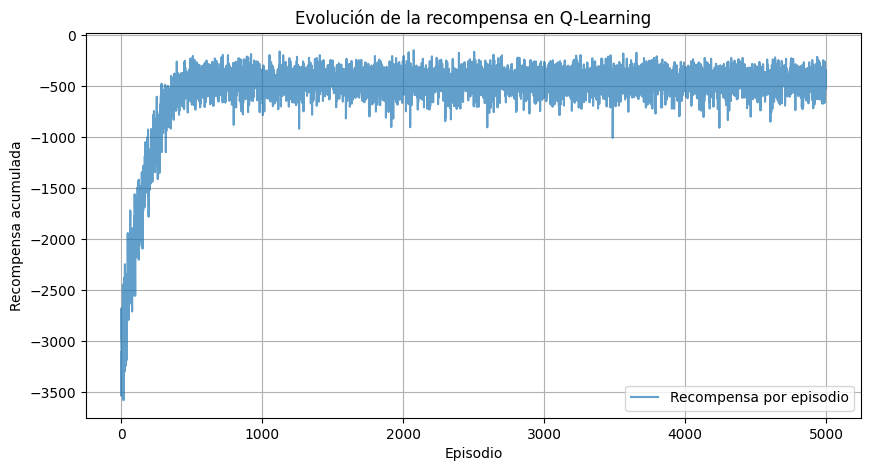

Recompensa promedio en los últimos 100 episodios: -448.65


In [22]:
np.save("qtable_microgrid.npy", Q_table)

plt.figure(figsize=(10,5))
plt.plot(episode_rewards, label="Recompensa por episodio", alpha=0.7)
plt.xlabel("Episodio")
plt.ylabel("Recompensa acumulada")
plt.title("Evolución de la recompensa en Q-Learning")
plt.legend()
plt.grid()
plt.show()

last_100_avg = np.mean(episode_rewards[-100:])
print(f"Recompensa promedio en los últimos 100 episodios: {last_100_avg:.2f}")

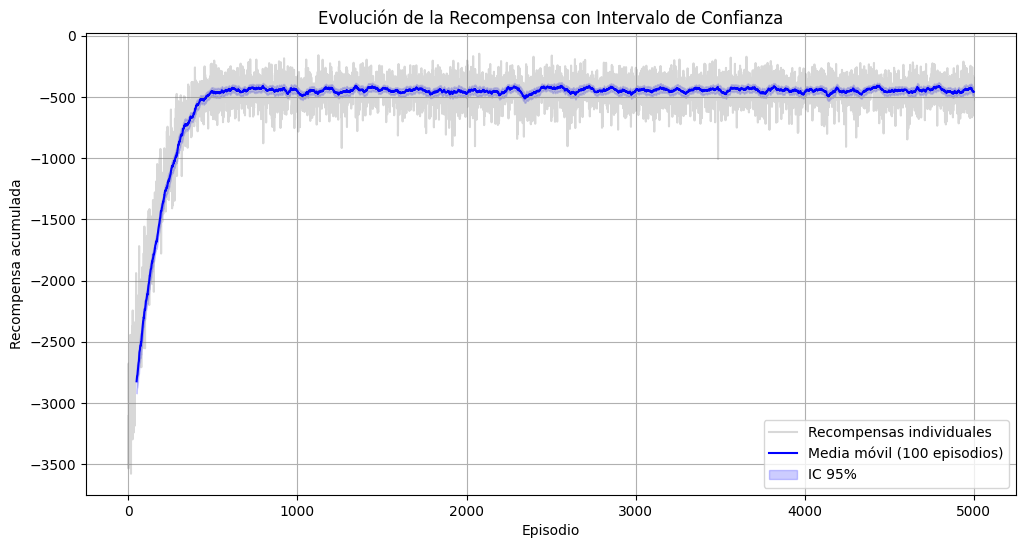

In [33]:
window_size = 50
episode_rewards_np = np.array(episode_rewards)

rolling_mean = np.convolve(episode_rewards_np, np.ones(window_size)/window_size, mode='valid')

rolling_std = np.array([np.std(episode_rewards_np[i:i+window_size])
                       for i in range(len(episode_rewards_np)-window_size+1)])

confidence = 1.96 * rolling_std / np.sqrt(window_size)
x_vals = np.arange(window_size-1, len(episode_rewards_np))

plt.figure(figsize=(12,6))
plt.plot(episode_rewards, label='Recompensas individuales', alpha=0.3, color='gray')
plt.plot(x_vals, rolling_mean, label='Media móvil (100 episodios)', color='blue')
plt.fill_between(x_vals,
                 rolling_mean - confidence,
                 rolling_mean + confidence,
                 color='blue', alpha=0.2, label='IC 95%')

plt.xlabel('Episodio')
plt.ylabel('Recompensa acumulada')
plt.title('Evolución de la Recompensa con Intervalo de Confianza')
plt.legend()
plt.grid(True)
plt.show()

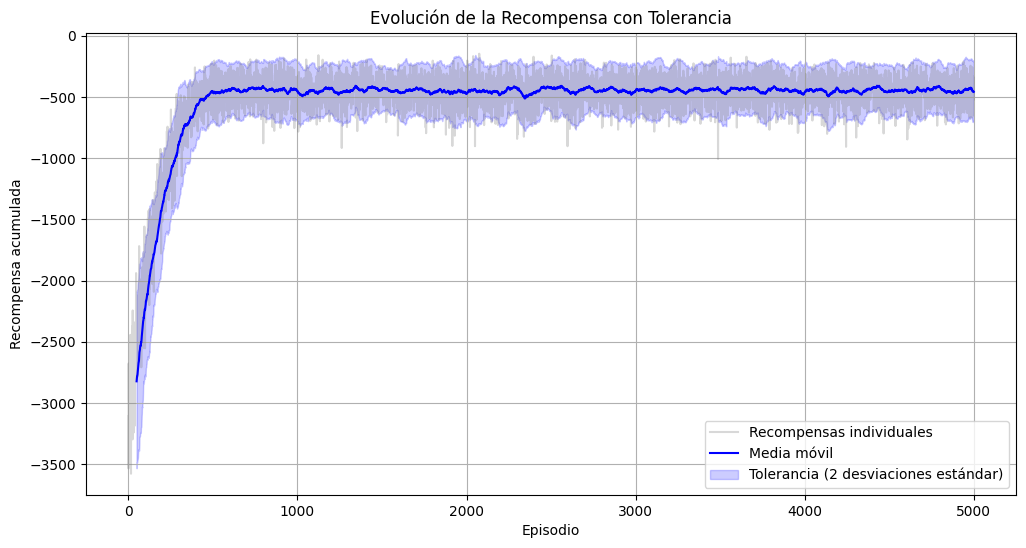

In [34]:
window_size = 50
episode_rewards_np = np.array(episode_rewards)

rolling_mean = np.convolve(episode_rewards_np, np.ones(window_size)/window_size, mode='valid')

rolling_std = np.array([np.std(episode_rewards_np[i:i+window_size])
                       for i in range(len(episode_rewards_np)-window_size+1)])

tolerance = 2 * rolling_std
x_vals = np.arange(window_size-1, len(episode_rewards_np))

plt.figure(figsize=(12,6))
plt.plot(episode_rewards, label='Recompensas individuales', alpha=0.3, color='gray')
plt.plot(x_vals, rolling_mean, label='Media móvil', color='blue')
plt.fill_between(x_vals,
                 rolling_mean - tolerance,
                 rolling_mean + tolerance,
                 color='blue', alpha=0.2, label='Tolerancia (2 desviaciones estándar)')

plt.xlabel('Episodio')
plt.ylabel('Recompensa acumulada')
plt.title('Evolución de la Recompensa con Tolerancia')
plt.legend()
plt.grid(True)
plt.show()


## TESTEO QLEARNING

In [23]:
archivo_subido = files.upload()

with zipfile.ZipFile("data_pv_high_load_low.zip", 'r') as zip_ref:
    zip_ref.extractall("./")  # Extraer en el directorio correcto

env_test1 = mg.MicrogridGenerator(nb_microgrid=5, path="./data_pv_high_load_low/data/pymgrid_data")

Saving data_pv_high_load_low.zip to data_pv_high_load_low.zip


In [24]:
archivo_subido = files.upload()

with zipfile.ZipFile("data_pv_low_load_high.zip", 'r') as zip_ref:
    zip_ref.extractall("./data_pv_low_load_high")

env_test2 = mg.MicrogridGenerator(nb_microgrid=5, path="./data_pv_low_load_high/data_pv_low_load_high/data/pymgrid_data")

Saving data_pv_low_load_high.zip to data_pv_low_load_high.zip


In [25]:
import pytest
import copy
import numpy as np
import random
import torch
from stable_baselines3.common.monitor import Monitor

env_gen = mg.MicrogridGenerator(nb_microgrid=5, path="./data/pymgrid_data")
env_test1 = mg.MicrogridGenerator(nb_microgrid=5, path="./data_pv_high_load_low/data/pymgrid_data")
env_test2 = mg.MicrogridGenerator(nb_microgrid=5, path="./data_pv_low_load_high/data_pv_low_load_high/data/pymgrid_data")

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

def simulate_env(model, microgrid, num_episodes=50):
    set_seed(42)
    simulation_env = MicrogridEnv(microgrid)
    simulation_env = Monitor(simulation_env)
    rewards = []

    for episode in range(num_episodes):
        obs, _ = simulation_env.reset(seed=42)
        done = False
        episode_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = simulation_env.step(action)
            episode_reward += reward
        rewards.append(episode_reward)

    return np.mean(rewards)

class QAgent:
    def __init__(self, qtable, bins_net, bins_soc):
        self.qtable = qtable
        self.bins_net = bins_net
        self.bins_soc = bins_soc

    def predict(self, state, deterministic=True):
        state_disc = discretize_state(state, self.bins_net, self.bins_soc)
        action = np.argmax(self.qtable[state_disc[0], state_disc[1]])
        return action, None

@pytest.fixture(scope="session")
def base_microgrid():
    env_gen.generate_microgrid(verbose=False)
    return copy.deepcopy(env_gen.microgrids[0])

@pytest.fixture
def trained_qagent_and_microgrid(base_microgrid):
    mg0 = copy.deepcopy(base_microgrid)

    temp_env = MicrogridEnv(mg0)
    low_obs = temp_env.observation_space.low
    high_obs = temp_env.observation_space.high
    bins_net = np.linspace(low_obs[0], high_obs[0], 20)
    bins_soc = np.linspace(low_obs[1], high_obs[1], 11)

    Q_table = np.load("qtable_microgrid.npy")
    q_agent = QAgent(Q_table, bins_net, bins_soc)

    return q_agent, mg0

def test_increased_load_qlearning(trained_qagent_and_microgrid):
    agent, mg0 = trained_qagent_and_microgrid
    avg_reward_orig = simulate_env(agent, mg0, num_episodes=200)

    env_test2.generate_microgrid(verbose=False)
    mg_mod = copy.deepcopy(env_test2.microgrids[0])

    avg_reward_mod = simulate_env(agent, mg_mod, num_episodes=200)

    assert avg_reward_mod < avg_reward_orig, (
        f"Con carga aumentada se esperaba un avg_reward menor (más negativo). "
        f"avg_reward original: {avg_reward_orig}, avg_reward modificado: {avg_reward_mod}"
    )
    print(f"Test 'increased load' passed: al aumentar la carga, el coste global es mayor. Coste medio original: {avg_reward_orig}. Coste medio modificado: {avg_reward_mod}")

def test_increased_pv_qlearning(trained_qagent_and_microgrid):
    agent, mg0 = trained_qagent_and_microgrid
    avg_reward_orig = simulate_env(agent, mg0, num_episodes=200)

    env_test1.generate_microgrid(verbose=False)
    mg_mod = copy.deepcopy(env_test1.microgrids[0])

    avg_reward_mod = simulate_env(agent, mg_mod, num_episodes=200)

    assert avg_reward_mod > avg_reward_orig, (
        f"Con PV aumentada se esperaba un avg_reward mayor. "
        f"avg_reward original: {avg_reward_orig}, avg_reward modificado: {avg_reward_mod}"
    )
    print(f"Test 'increased pv' passed: al aumentar la generación PV, el coste global es menor. Coste medio original: {avg_reward_orig}. Coste medio modificado: {avg_reward_mod}")


In [26]:
!pip install ipytest

In [27]:
import ipytest
ipytest.autoconfig()
ipytest.run("--maxfail=2", "--disable-warnings", "-s")

Test 'increased load' passed: al aumentar la carga, el coste global es mayor. Coste medio original: -146.7741239093006. Coste medio modificado: -702.5002802410279
.Test 'increased pv' passed: al aumentar la generación PV, el coste global es menor. Coste medio original: -146.7741239093006. Coste medio modificado: -116.74313968389721
.
2 passed, 15 warnings in 92.11s (0:01:32)


<ExitCode.OK: 0>